# Load all notebooks with Functions

In [0]:
%run /Users/pnl0rc8b@emea.royalahold.net/FINALIZED_Notebooks/Functions_Finalized

In [0]:
%run /Users/pnl0rc8b@emea.royalahold.net/FINALIZED_Notebooks/Functions_Tables

Out[179]: ' Plot de distributie van de classes die aanwezig zijn in het DESBETREFFENDE attribuut '

# Hoe doe ik mijn eigen analyse? Voorbeeld:
Correlation matrix: Als een numerieke feature beneden de 0.20 zit is het niet intressant om deze mee te nemen als extra feature. Als de value dichtbij de -1 of 1 is, dan heeft het een sterkte relatie met het attribuut. 
Let op bij de UOM classes, deze kunnen soms voor iets slechtere prestaties zorgen. Dus controleer altijd de prestatie:     1. Zonder numerieke features         2. Inclusief features.
<div style="text-align: center; line-height: 10; padding-top: 30px;  padding-bottom: 30px;">
  <img src="https://raw.githubusercontent.com/MarcB77/Master_Thesis_AI/main/logos/notebook_explanation/correlation_no.png" alt='corr_no' style="width: 600px" >
</div>

# Configureer Parameters

In [0]:
ATTRIBUUT = "ndDairyType" # Selecteer Attribuut om te TRAINEN                                           
numerieke_features = [''] #['SUGAR_was_missing','SUGAR_UOM_class','SUGAR']#['FIBER','FIBER_was_missing','Fiber_UOM_class','PROTEINE'] # Deze numerieke features nemen we mee in het trainingsprocess, leeg is ook mogelijk --> []

SAVE_MODEL = True #True # Wil je een oud model overschrijven met een nieuwe?

#Multi-label
Classes_threshold = 11
Overig_threshold = 50 # Class beneden deze threshold, zal worden toegevoegd aan class: 'overig'


#Single-label zie CMD 8 na runnen of balans goed is.
upsample_single_label_threshold = 2500  # Indien een class lager is dan deze threshold, wordt de class geupsampled tot deze ingestelde threshold.                       
downsampeling_needed = False #cmd 8 zie je de balans van attributen, als 1 attribuutwaarde teveel verschilt van alle andere, dan geen upsampling maar downsampling. 


# Indien andere numeriek features dan -> nutrienten is gewenst, zie dan: Functions_Tables
# Multi-label heeft geen tweaks nodig
Upsample_size_TRAIN = 4000
Upsample_size_VAL = 1000
Upsample_size_TEST = 1000
EPOCHS = 75 # Aantal Epochs voor Single-label.
EPOCHS_MULTI_label = 30 # default=30

/databricks/spark/python/pyspark/sql/dataframe.py:146: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
 warnings.warn(
(47485, 20)
Shape van DF (row, columns) (33710, 8)

# Training Process loop

Downsampeling gebruiken als je een attribuut hebt die hele ongebalanceerde classes hebt (bijv. 5000 True, 5000 False en 20000 Empty), alles wordt dan even groot als de kleinste class (equal_classes_downsample). Als dit niet nodig is dan gebruik je imbalance_check_single_label. Zet boolean downsampeling_need op True in cmd 5 indien gewenst.

In [0]:
save_numerical_features_(SAVE_MODEL,ATTRIBUUT, numerieke_features)
if numerieke_features == ['']:
    numerieke_features = []

Amount of rows: 34439 Amount of columns: 139
ATTRIBUUT: ndDairyType
Kleine classes die onder overige moeten: ['Cacaoboter', 'Chocomelk', 'Creme fraiche', 'Halvarine', 'Karnemelk', 'Kefir', 'Koffiemelk', 'Kruidenboter', 'Margarine', 'Pudding', 'Skyr', 'Vla', 'Zuivelspread', 'Zure room']
Kleine classes, aantallen: [26, 42, 4, 7, 17, 11, 20, 16, 42, 36, 29, 19, 8, 16]
Grotere classes: ['Boter', 'Drinkyoghurt', 'EMPTY', 'Kwark', 'Melk', 'Room', 'Roomboter', 'Slagroom', 'Yoghurt']
Grotere classes, aantallen: [57, 58, 33145, 83, 245, 293, 199, 53, 328]
null entries = 0
Shape van dataframe: (23162, 34)
null entries = 683

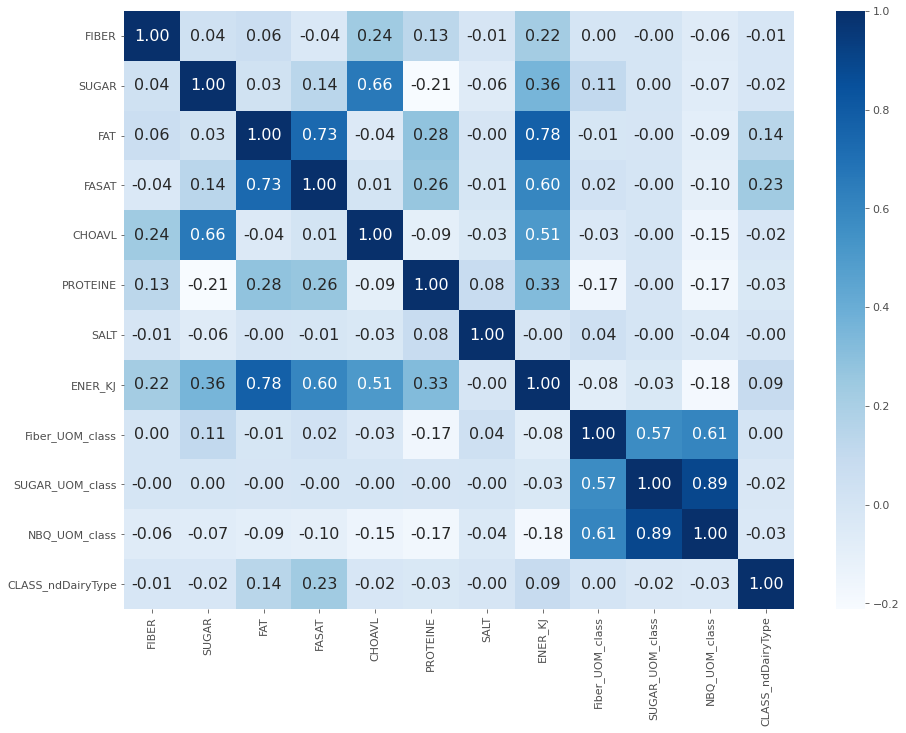

Vocab size: 39801.0
(13487, 6) (4496, 6) (4496, 6)
(13487, 10) (4496, 10) (4496, 10)

In [0]:
# Formateer
nd_controle = koppel_ndAttributen_new_products(NASA_CONTROLE)
df_geformateerd, multi_label_flag,classes_available = create_overige_class(nd_controle, ATTRIBUUT,Classes_threshold, Overig_threshold)

DF_merged = koppel_preprocessed_text(df_geformateerd, DF_NLP_spark)
DF_merged = fix_empty_fields(DF_merged, ATTRIBUUT)
DF_merged = Correlation_matrix(DF_merged, ATTRIBUUT, show_nan_plot=False, show_correlation_matrix=True)

#Prepare for training
vocab_size = get_vocabulary_size(DF_merged)

if multi_label_flag == True:
    X_train, X_val, X_test, y_train, y_val, y_test, targets = total_split(DF_merged, numerieke_features, ATTRIBUUT)
else:
    if downsampeling_needed == True:
        DF_merged = equal_classes_downsample(classes_available, DF_merged)
    else:
        DF_merged = imbalance_check_single_label(classes_available, DF_merged, upsample_single_label_threshold)
    ytrain, yval, ytest, Xtrain_num, Xtrain_text, Xval_num, Xval_text, Xtest_num, Xtest_text = single_prep(numerieke_features, DF_merged, ATTRIBUUT)

In [0]:
if multi_label_flag == True:
    classes = DF_merged['overig'].value_counts().index.tolist() # haal [0,1] en [1,0] als class eruit
    X_train, y_train = balance_multi_label(targets, y_train, X_train, classes, Upsample_size_TRAIN, balance_set = "TRAIN-SET") # Balance each sub-class TRAINING
    X_val, y_val = balance_multi_label(targets, y_val, X_val, classes, Upsample_size_VAL, balance_set = "VALIDATION-SET") # Balance each sub-class VALIDATION
    X_test, y_test = balance_multi_label(targets, y_test, X_test, classes, Upsample_size_TEST, balance_set = "TEST-SET") # Balance each sub-class TEST

    train_accuracies, val_accuracies, train_loss, val_loss,class_names, model = TRAINING_multi_label(X_train, X_val, X_test, y_train, y_val, y_test, numerieke_features, vocab_size, ATTRIBUUT, SAVE_MODEL, EPOCHS_MULTI_label) # Start training the model --> Multi-Label
else:
    model, model_history = TRAINING_single_label(Xtrain_num, Xtrain_text, Xval_num, Xval_text, Xtest_num, Xtest_text, vocab_size, EPOCHS, SAVE_MODEL) # Start training the model --> Single-Label


----------- BALANCING TRAIN-SET -----------

Samples available Boter 32 
Searching for: [0, 1]
Shape before upsampling minority class 13487 13487
Add Extra samples Y_train | X_Train 3968 3968
New shape 17455 17455

Samples available Drinkyoghurt 31 
Searching for: [0, 1]
Shape before upsampling minority class 17455 17455
Add Extra samples Y_train | X_Train 3969 3969
New shape 21424 21424

Samples available EMPTY 12722 
Searching for: [0, 1]

Samples available Kwark 54 
Searching for: [0, 1]
Shape before upsampling minority class 21424 21424
Add Extra samples Y_train | X_Train 3946 3946
New shape 25370 25370

Samples available Melk 144 
Searching for: [0, 1]
Shape before upsampling minority class 25370 25370
Add Extra samples Y_train | X_Train 3856 3856
New shape 29226 29226

Samples available Room 489 
Searching for: [0, 1]
Shape before upsampling minority class 29226 29226
Add Extra samples Y_train | X_Train 3511 3511
New shape 32737 32737

Samples available Roomboter 3004 
Searching for: [0, 1]
Shape before upsampling minority class 32737 32737
Add Extra samples Y_train | X_Train 996 996
New shape 33733 33733

Samples available Slagroom 148 
Searching for: [0, 1]
Shape before upsampling minority class 33733 33733
Add Extra samples Y_train | X_Train 3852 3852
New shape 37585 37585

Samples available Yoghurt 1235 
Searching for: [0, 1]
Shape before upsampling minority class 37585 37585
Add Extra samples Y_train | X_Train 2765 2765
New shape 40350 40350

Samples available overig 961 
Searching for: [0, 1]
Shape before upsampling minority class 40350 40350
Add Extra samples Y_train | X_Train 3039 3039
New shape 43389 43389

----------- BALANCING VALIDATION-SET -----------

Samples available Boter 13 
Searching for: [0, 1]
Shape before upsampling minority class 4496 4496
Add Extra samples Y_train | X_Train 987 987
New shape 5483 5483

Samples available Drinkyoghurt 8 
Searching for: [0, 1]
Shape before upsampling minority class 5483 5483
Add Extra samples Y_train | X_Train 992 992
New shape 6475 6475

Samples available EMPTY 4274 
Searching for: [0, 1]

Samples available Kwark 13 
Searching for: [0, 1]
Shape before upsampling minority class 6475 6475
Add Extra samples Y_train | X_Train 987 987
New shape 7462 7462

Samples available Melk 37 
Searching for: [0, 1]
Shape before upsampling minority class 7462 7462
Add Extra samples Y_train | X_Train 963 963
New shape 8425 8425

Samples available Room 333 
Searching for: [0, 1]
Shape before upsampling minority class 8425 8425
Add Extra samples Y_train | X_Train 667 667
New shape 9092 9092

Samples available Roomboter 949 
Searching for: [0, 1]
Shape before upsampling minority class 9092 9092
Add Extra samples Y_train | X_Train 51 51
New shape 9143 9143

Samples available Slagroom 9 
Searching for: [0, 1]
Shape before upsampling minority class 9143 9143
Add Extra samples Y_train | X_Train 991 991
New shape 10134 10134

Samples available Yoghurt 244 
Searching for: [0, 1]
Shape before upsampling minority class 10134 10134
Add Extra samples Y_train | X_Train 756 756
New shape 10890 10890

Samples available overig 299 
Searching for: [0, 1]
Shape before upsampling minority class 10890 10890
Add Extra samples Y_train | X_Train 701 701
New shape 11591 11591

----------- BALANCING TEST-SET -----------

Samples available Boter 9 
Searching for: [0, 1]
Shape before upsampling minority class 4496 4496
Add Extra samples Y_train | X_Train 991 991
New shape 5487 5487

Samples available Drinkyoghurt 16 
Searching for: [0, 1]
Shape before upsampling minority class 5487 5487
Add Extra samples Y_train | X_Train 984 984
New shape 6471 6471

Samples available EMPTY 4224 
Searching for: [0, 1]

Samples available Kwark 16 
Searching for: [0, 1]
Shape before upsampling minority class 6471 6471
Add Extra samples Y_train | X_Train 984 984
New shape 7455 7455

Samples available Melk 113 
Searching for: [0, 1]
Shape before upsampling minority class 7455 7455
Add Extra samples Y_train | X_Train 887 887
New shap

path,name,size,modificationTime
dbfs:/FileStore/nd_MODELS/ndDairyType/model_Boter.h5,model_Boter.h5,1194968,1657184900000


Drinkyoghurt
X-Train | X-Validation | X-Test ## Numerical shape (43389, 0) (11591, 0) (11761, 0)
X-Train | X-Validation | X-Test ## Textual shape (43389, 301) (11591, 301) (11761, 301)
Y-Train | Y-Validation | Y-Test ## TARGET shape (43389, 2) (11591, 2) (11761, 2)
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type) Output Shape Param # Connected to 
==================================================================================================
 input_22 (InputLayer) [(None, 301)] 0 [] 
 
 embedding_10 (Embedding) (None, 301, 4) 159204 ['input_22[0][0]'] 
 
 flatten_10 (Flatten) (None, 1204) 0 ['embedding_10[0][0]'] 
 
 input_21 (InputLayer) [(None, 0)] 0 [] 
 
 dropout_31 (Dropout) (None, 1204) 0 ['flatten_10[0][0]'] 
 
 dropout_30 (Dropout) (None, 0) 0 ['input_21[0][0]'] 
 
 concatenate_10 (Concatenate) (None, 1204) 0 ['dropout_31[0][0]', 
 'dropout_30[0][0]'] 
 
 dense_40 (Dense) (None, 100) 120500 ['concatenate_10[0][0]'] 
 
 dense_41 (Dense) (None, 50) 5050 ['dense_40[0][0]'] 
 
 dense_42 (Dense) (None, 100) 5100 ['dense_41[0][0]'] 
 
 dropout_32 (Dropout) (None, 100) 0 ['dense_42[0][0]'] 
 
 dense_43 (Dense) (None, 2) 202 ['dropout_32[0][0]'] 
 
==================================================================================================
Total params: 290,056
Trainable params: 290,056
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/30
1356/1356 - 4s - loss: 0.3479 - accuracy: 0.9011 - val_loss: 0.3517 - val_accuracy: 0.8826 - 4s/epoch - 3ms/step
Epoch 2/30
1356/1356 - 4s - loss: 0.3092 - accuracy: 0.9011 - val_loss: 0.3157 - val_accuracy: 0.8826 - 4s/epoch - 3ms/step
Epoch 3/30
1356/1356 - 4s - loss: 0.2658 - accuracy: 0.9011 - val_loss: 0.2264 - val_accuracy: 0.8826 - 4s/epoch - 3ms/step
Epoch 4/30
1356/1356 - 4s - loss: 0.1389 - accuracy: 0.9338 - val_loss: 0.1183 - val_accuracy: 0.9362 - 4s/epoch - 3ms/step
Epoch 5/30
1356/1356 - 3s - loss: 0.0555 - accuracy: 0.9924 - val_loss: 0.0904 - val_accuracy: 0.9474 - 3s/epoch - 3ms/step
Epoch 6/30
1356/1356 - 3s - loss: 0.0185 - accuracy: 0.9969 - val_loss: 0.0691 - val_accuracy: 0.9474 - 3s/epoch - 3ms/step
Epoch 7/30
1356/1356 - 4s - loss: 0.0086 - accuracy: 0.9987 - val_loss: 0.0755 - val_accuracy: 0.9476 - 4s/epoch - 3ms/step
Epoch 8/30
1356/1356 - 3s - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.0440 - val_accuracy: 0.9584 - 3s/epoch - 3ms/step
Epoch 9/30
1356/1356 - 4s - loss: 0.0047 - accuracy: 0.9992 - val_loss: 0.0753 - val_accuracy: 0.9587 - 4s/epoch - 3ms/step
Epoch 10/30
1356/1356 - 4s - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.0700 - val_accuracy: 0.9587 - 4s/epoch - 3ms/step
Epoch 11/30
1356/1356 - 4s - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.0719 - val_accuracy: 0.9587 - 4s/epoch - 3ms/step
Epoch 12/30
1356/1356 - 4s - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0604 - val_accuracy: 0.9587 - 4s/epoch - 3ms/step
Epoch 13/30
1356/1356 - 4s - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0598 - val_accuracy: 0.9587 - 4s/epoch - 3ms/step
Epoch 14/30
1356/1356 - 4s - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0962 - val_accuracy: 0.9587 - 4s/epoch - 3ms/step
Epoch 15/30
1356/1356 - 4s - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0749 - val_accuracy: 0.9587 - 4s/epoch - 3ms/step
Epoch 16/30
1356/1356 - 4s - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0751 - val_accuracy: 0.9587 - 4s/epoch - 3ms/step
Epoch 17/30
1356/1356 - 4s - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0959 - val_accuracy: 0.9587 - 4s/epoch - 3ms/step
Epoch 18/30
1356/1356 - 4s - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0620 - val_accuracy: 0.9587 - 4s/epoch - 3ms/step
Epoch 19/30
1356/1356 - 4s - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0739 - val_accuracy: 0.9587 - 4s/epoch - 3ms/step
Epoch 20/30
1356/1356 - 4s - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0877 - val_accuracy: 0.9587 - 4s/epoc

path,name,size,modificationTime
dbfs:/FileStore/nd_MODELS/ndDairyType/model_Drinkyoghurt.h5,model_Drinkyoghurt.h5,1194968,1657185009000


EMPTY
X-Train | X-Validation | X-Test ## Numerical shape (43389, 0) (11591, 0) (11761, 0)
X-Train | X-Validation | X-Test ## Textual shape (43389, 301) (11591, 301) (11761, 301)
Y-Train | Y-Validation | Y-Test ## TARGET shape (43389, 2) (11591, 2) (11761, 2)
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type) Output Shape Param # Connected to 
==================================================================================================
 input_24 (InputLayer) [(None, 301)] 0 [] 
 
 embedding_11 (Embedding) (None, 301, 4) 159204 ['input_24[0][0]'] 
 
 flatten_11 (Flatten) (None, 1204) 0 ['embedding_11[0][0]'] 
 
 input_23 (InputLayer) [(None, 0)] 0 [] 
 
 dropout_34 (Dropout) (None, 1204) 0 ['flatten_11[0][0]'] 
 
 dropout_33 (Dropout) (None, 0) 0 ['input_23[0][0]'] 
 
 concatenate_11 (Concatenate) (None, 1204) 0 ['dropout_34[0][0]', 
 'dropout_33[0][0]'] 
 
 dense_44 (Dense) (None, 100) 120500 ['concatenate_11[0][0]'] 
 
 dense_45 (Dense) (None, 50) 5050 ['dense_44[0][0]'] 
 
 dense_46 (Dense) (None, 100) 5100 ['dense_45[0][0]'] 
 
 dropout_35 (Dropout) (None, 100) 0 ['dense_46[0][0]'] 
 
 dense_47 (Dense) (None, 2) 202 ['dropout_35[0][0]'] 
 
==================================================================================================
Total params: 290,056
Trainable params: 290,056
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/30
1356/1356 - 4s - loss: 0.6241 - accuracy: 0.7039 - val_loss: 0.6678 - val_accuracy: 0.6313 - 4s/epoch - 3ms/step
Epoch 2/30
1356/1356 - 4s - loss: 0.6047 - accuracy: 0.7068 - val_loss: 0.6677 - val_accuracy: 0.6313 - 4s/epoch - 3ms/step
Epoch 3/30
1356/1356 - 4s - loss: 0.6014 - accuracy: 0.7068 - val_loss: 0.6495 - val_accuracy: 0.6313 - 4s/epoch - 3ms/step
Epoch 4/30
1356/1356 - 3s - loss: 0.5924 - accuracy: 0.7068 - val_loss: 0.6439 - val_accuracy: 0.6313 - 3s/epoch - 3ms/step
Epoch 5/30
1356/1356 - 3s - loss: 0.5602 - accuracy: 0.7092 - val_loss: 0.5739 - val_accuracy: 0.6313 - 3s/epoch - 3ms/step
Epoch 6/30
1356/1356 - 4s - loss: 0.3792 - accuracy: 0.8241 - val_loss: 0.2914 - val_accuracy: 0.8954 - 4s/epoch - 3ms/step
Epoch 7/30
1356/1356 - 3s - loss: 0.1946 - accuracy: 0.9280 - val_loss: 0.1757 - val_accuracy: 0.9418 - 3s/epoch - 3ms/step
Epoch 8/30
1356/1356 - 4s - loss: 0.1335 - accuracy: 0.9524 - val_loss: 0.1729 - val_accuracy: 0.9343 - 4s/epoch - 3ms/step
Epoch 9/30
1356/1356 - 4s - loss: 0.1054 - accuracy: 0.9636 - val_loss: 0.1546 - val_accuracy: 0.9375 - 4s/epoch - 3ms/step
Epoch 10/30
1356/1356 - 4s - loss: 0.0865 - accuracy: 0.9699 - val_loss: 0.1793 - val_accuracy: 0.9299 - 4s/epoch - 3ms/step
Epoch 11/30
1356/1356 - 4s - loss: 0.0751 - accuracy: 0.9748 - val_loss: 0.1370 - val_accuracy: 0.9450 - 4s/epoch - 3ms/step
Epoch 12/30
1356/1356 - 4s - loss: 0.0676 - accuracy: 0.9771 - val_loss: 0.1799 - val_accuracy: 0.9393 - 4s/epoch - 3ms/step
Epoch 13/30
1356/1356 - 4s - loss: 0.0562 - accuracy: 0.9823 - val_loss: 0.1565 - val_accuracy: 0.9439 - 4s/epoch - 3ms/step
Epoch 14/30
1356/1356 - 4s - loss: 0.0522 - accuracy: 0.9833 - val_loss: 0.1718 - val_accuracy: 0.9378 - 4s/epoch - 3ms/step
Epoch 15/30
1356/1356 - 4s - loss: 0.0494 - accuracy: 0.9837 - val_loss: 0.1793 - val_accuracy: 0.9435 - 4s/epoch - 3ms/step
Epoch 16/30
1356/1356 - 4s - loss: 0.0425 - accuracy: 0.9867 - val_loss: 0.2347 - val_accuracy: 0.9182 - 4s/epoch - 3ms/step
Epoch 17/30
1356/1356 - 4s - loss: 0.0380 - accuracy: 0.9882 - val_loss: 0.2292 - val_accuracy: 0.9278 - 4s/epoch - 3ms/step
Epoch 18/30
1356/1356 - 4s - loss: 0.0345 - accuracy: 0.9890 - val_loss: 0.2565 - val_accuracy: 0.9217 - 4s/epoch - 3ms/step
Epoch 19/30
1356/1356 - 4s - loss: 0.0351 - accuracy: 0.9887 - val_loss: 0.2546 - val_accuracy: 0.9175 - 4s/epoch - 3ms/step
Epoch 20/30
1356/1356 - 4s - loss: 0.0305 - accuracy: 0.9906 - val_loss: 0.3301 - val_accuracy: 0.9003 - 4s/epoch - 3ms

path,name,size,modificationTime
dbfs:/FileStore/nd_MODELS/ndDairyType/model_EMPTY.h5,model_EMPTY.h5,1194968,1657185118000


Kwark
X-Train | X-Validation | X-Test ## Numerical shape (43389, 0) (11591, 0) (11761, 0)
X-Train | X-Validation | X-Test ## Textual shape (43389, 301) (11591, 301) (11761, 301)
Y-Train | Y-Validation | Y-Test ## TARGET shape (43389, 2) (11591, 2) (11761, 2)
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type) Output Shape Param # Connected to 
==================================================================================================
 input_26 (InputLayer) [(None, 301)] 0 [] 
 
 embedding_12 (Embedding) (None, 301, 4) 159204 ['input_26[0][0]'] 
 
 flatten_12 (Flatten) (None, 1204) 0 ['embedding_12[0][0]'] 
 
 input_25 (InputLayer) [(None, 0)] 0 [] 
 
 dropout_37 (Dropout) (None, 1204) 0 ['flatten_12[0][0]'] 
 
 dropout_36 (Dropout) (None, 0) 0 ['input_25[0][0]'] 
 
 concatenate_12 (Concatenate) (None, 1204) 0 ['dropout_37[0][0]', 
 'dropout_36[0][0]'] 
 
 dense_48 (Dense) (None, 100) 120500 ['concatenate_12[0][0]'] 
 
 dense_49 (Dense) (None, 50) 5050 ['dense_48[0][0]'] 
 
 dense_50 (Dense) (None, 100) 5100 ['dense_49[0][0]'] 
 
 dropout_38 (Dropout) (None, 100) 0 ['dense_50[0][0]'] 
 
 dense_51 (Dense) (None, 2) 202 ['dropout_38[0][0]'] 
 
==================================================================================================
Total params: 290,056
Trainable params: 290,056
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/30
1356/1356 - 4s - loss: 0.5256 - accuracy: 0.7932 - val_loss: 0.3463 - val_accuracy: 0.9137 - 4s/epoch - 3ms/step
Epoch 2/30
1356/1356 - 4s - loss: 0.4557 - accuracy: 0.7972 - val_loss: 0.2994 - val_accuracy: 0.9137 - 4s/epoch - 3ms/step
Epoch 3/30
1356/1356 - 4s - loss: 0.2096 - accuracy: 0.9313 - val_loss: 0.1536 - val_accuracy: 0.9435 - 4s/epoch - 3ms/step
Epoch 4/30
1356/1356 - 4s - loss: 0.0411 - accuracy: 0.9901 - val_loss: 0.1060 - val_accuracy: 0.9778 - 4s/epoch - 3ms/step
Epoch 5/30
1356/1356 - 4s - loss: 0.0154 - accuracy: 0.9965 - val_loss: 0.1101 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 6/30
1356/1356 - 4s - loss: 0.0090 - accuracy: 0.9981 - val_loss: 0.1124 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 7/30
1356/1356 - 4s - loss: 0.0060 - accuracy: 0.9986 - val_loss: 0.1148 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 8/30
1356/1356 - 4s - loss: 0.0054 - accuracy: 0.9989 - val_loss: 0.1212 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 9/30
1356/1356 - 4s - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.1234 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 10/30
1356/1356 - 4s - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.1264 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 11/30
1356/1356 - 4s - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.1266 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 12/30
1356/1356 - 4s - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.1309 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 13/30
1356/1356 - 4s - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.1330 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 14/30
1356/1356 - 4s - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.1347 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 15/30
1356/1356 - 4s - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.1379 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 16/30
1356/1356 - 4s - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.1399 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 17/30
1356/1356 - 4s - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.1406 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 18/30
1356/1356 - 4s - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.1437 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 19/30
1356/1356 - 4s - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.1482 - val_accuracy: 0.9779 - 4s/epoch - 3ms/step
Epoch 20/30
1356/1356 - 4s - loss: 8.5936e-04 - accuracy: 0.9999 - val_loss: 0.1514 - val_accuracy: 0.9779 - 4s/epoch -

path,name,size,modificationTime
dbfs:/FileStore/nd_MODELS/ndDairyType/model_Kwark.h5,model_Kwark.h5,1194968,1657185228000


Melk
X-Train | X-Validation | X-Test ## Numerical shape (43389, 0) (11591, 0) (11761, 0)
X-Train | X-Validation | X-Test ## Textual shape (43389, 301) (11591, 301) (11761, 301)
Y-Train | Y-Validation | Y-Test ## TARGET shape (43389, 2) (11591, 2) (11761, 2)
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type) Output Shape Param # Connected to 
==================================================================================================
 input_28 (InputLayer) [(None, 301)] 0 [] 
 
 embedding_13 (Embedding) (None, 301, 4) 159204 ['input_28[0][0]'] 
 
 flatten_13 (Flatten) (None, 1204) 0 ['embedding_13[0][0]'] 
 
 input_27 (InputLayer) [(None, 0)] 0 [] 
 
 dropout_40 (Dropout) (None, 1204) 0 ['flatten_13[0][0]'] 
 
 dropout_39 (Dropout) (None, 0) 0 ['input_27[0][0]'] 
 
 concatenate_13 (Concatenate) (None, 1204) 0 ['dropout_40[0][0]', 
 'dropout_39[0][0]'] 
 
 dense_52 (Dense) (None, 100) 120500 ['concatenate_13[0][0]'] 
 
 dense_53 (Dense) (None, 50) 5050 ['dense_52[0][0]'] 
 
 dense_54 (Dense) (None, 100) 5100 ['dense_53[0][0]'] 
 
 dropout_41 (Dropout) (None, 100) 0 ['dense_54[0][0]'] 
 
 dense_55 (Dense) (None, 2) 202 ['dropout_41[0][0]'] 
 
==================================================================================================
Total params: 290,056
Trainable params: 290,056
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/30
1356/1356 - 4s - loss: 0.4009 - accuracy: 0.8809 - val_loss: 0.3817 - val_accuracy: 0.8730 - 4s/epoch - 3ms/step
Epoch 2/30
1356/1356 - 4s - loss: 0.3629 - accuracy: 0.8811 - val_loss: 0.3731 - val_accuracy: 0.8730 - 4s/epoch - 3ms/step
Epoch 3/30
1356/1356 - 4s - loss: 0.3538 - accuracy: 0.8811 - val_loss: 0.3653 - val_accuracy: 0.8730 - 4s/epoch - 3ms/step
Epoch 4/30
1356/1356 - 4s - loss: 0.3375 - accuracy: 0.8811 - val_loss: 0.3542 - val_accuracy: 0.8730 - 4s/epoch - 3ms/step
Epoch 5/30
1356/1356 - 4s - loss: 0.2865 - accuracy: 0.8815 - val_loss: 0.2931 - val_accuracy: 0.8730 - 4s/epoch - 3ms/step
Epoch 6/30
1356/1356 - 4s - loss: 0.1786 - accuracy: 0.9368 - val_loss: 0.1939 - val_accuracy: 0.9311 - 4s/epoch - 3ms/step
Epoch 7/30
1356/1356 - 4s - loss: 0.1022 - accuracy: 0.9705 - val_loss: 0.1528 - val_accuracy: 0.9519 - 4s/epoch - 3ms/step
Epoch 8/30
1356/1356 - 4s - loss: 0.0642 - accuracy: 0.9799 - val_loss: 0.1415 - val_accuracy: 0.9671 - 4s/epoch - 3ms/step
Epoch 9/30
1356/1356 - 4s - loss: 0.0443 - accuracy: 0.9857 - val_loss: 0.1475 - val_accuracy: 0.9540 - 4s/epoch - 3ms/step
Epoch 10/30
1356/1356 - 4s - loss: 0.0330 - accuracy: 0.9895 - val_loss: 0.1587 - val_accuracy: 0.9563 - 4s/epoch - 3ms/step
Epoch 11/30
1356/1356 - 4s - loss: 0.0245 - accuracy: 0.9926 - val_loss: 0.1740 - val_accuracy: 0.9569 - 4s/epoch - 3ms/step
Epoch 12/30
1356/1356 - 4s - loss: 0.0229 - accuracy: 0.9929 - val_loss: 0.1844 - val_accuracy: 0.9569 - 4s/epoch - 3ms/step
Epoch 13/30
1356/1356 - 4s - loss: 0.0197 - accuracy: 0.9941 - val_loss: 0.1671 - val_accuracy: 0.9560 - 4s/epoch - 3ms/step
Epoch 14/30
1356/1356 - 4s - loss: 0.0165 - accuracy: 0.9955 - val_loss: 0.2067 - val_accuracy: 0.9474 - 4s/epoch - 3ms/step
Epoch 15/30
1356/1356 - 4s - loss: 0.0148 - accuracy: 0.9955 - val_loss: 0.1932 - val_accuracy: 0.9562 - 4s/epoch - 3ms/step
Epoch 16/30
1356/1356 - 3s - loss: 0.0148 - accuracy: 0.9958 - val_loss: 0.2196 - val_accuracy: 0.9450 - 3s/epoch - 3ms/step
Epoch 17/30
1356/1356 - 4s - loss: 0.0126 - accuracy: 0.9962 - val_loss: 0.1981 - val_accuracy: 0.9498 - 4s/epoch - 3ms/step
Epoch 18/30
1356/1356 - 3s - loss: 0.0108 - accuracy: 0.9971 - val_loss: 0.2130 - val_accuracy: 0.9498 - 3s/epoch - 3ms/step
Epoch 19/30
1356/1356 - 3s - loss: 0.0110 - accuracy: 0.9970 - val_loss: 0.2157 - val_accuracy: 0.9478 - 3s/epoch - 3ms/step
Epoch 20/30
1356/1356 - 4s - loss: 0.0103 - accuracy: 0.9968 - val_loss: 0.2206 - val_accuracy: 0.9477 - 4s/epoch - 3ms/

path,name,size,modificationTime
dbfs:/FileStore/nd_MODELS/ndDairyType/model_Melk.h5,model_Melk.h5,1194968,1657185338000


Room
X-Train | X-Validation | X-Test ## Numerical shape (43389, 0) (11591, 0) (11761, 0)
X-Train | X-Validation | X-Test ## Textual shape (43389, 301) (11591, 301) (11761, 301)
Y-Train | Y-Validation | Y-Test ## TARGET shape (43389, 2) (11591, 2) (11761, 2)
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type) Output Shape Param # Connected to 
==================================================================================================
 input_30 (InputLayer) [(None, 301)] 0 [] 
 
 embedding_14 (Embedding) (None, 301, 4) 159204 ['input_30[0][0]'] 
 
 flatten_14 (Flatten) (None, 1204) 0 ['embedding_14[0][0]'] 
 
 input_29 (InputLayer) [(None, 0)] 0 [] 
 
 dropout_43 (Dropout) (None, 1204) 0 ['flatten_14[0][0]'] 
 
 dropout_42 (Dropout) (None, 0) 0 ['input_29[0][0]'] 
 
 concatenate_14 (Concatenate) (None, 1204) 0 ['dropout_43[0][0]', 
 'dropout_42[0][0]'] 
 
 dense_56 (Dense) (None, 100) 120500 ['concatenate_14[0][0]'] 
 
 dense_57 (Dense) (None, 50) 5050 ['dense_56[0][0]'] 
 
 dense_58 (Dense) (None, 100) 5100 ['dense_57[0][0]'] 
 
 dropout_44 (Dropout) (None, 100) 0 ['dense_58[0][0]'] 
 
 dense_59 (Dense) (None, 2) 202 ['dropout_44[0][0]'] 
 
==================================================================================================
Total params: 290,056
Trainable params: 290,056
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/30
1356/1356 - 4s - loss: 0.4686 - accuracy: 0.8491 - val_loss: 0.3354 - val_accuracy: 0.8986 - 4s/epoch - 3ms/step
Epoch 2/30
1356/1356 - 4s - loss: 0.4179 - accuracy: 0.8520 - val_loss: 0.3351 - val_accuracy: 0.8986 - 4s/epoch - 3ms/step
Epoch 3/30
1356/1356 - 4s - loss: 0.4071 - accuracy: 0.8520 - val_loss: 0.3265 - val_accuracy: 0.8986 - 4s/epoch - 3ms/step
Epoch 4/30
1356/1356 - 4s - loss: 0.3660 - accuracy: 0.8520 - val_loss: 0.2675 - val_accuracy: 0.8986 - 4s/epoch - 3ms/step
Epoch 5/30
1356/1356 - 4s - loss: 0.2812 - accuracy: 0.8912 - val_loss: 0.2479 - val_accuracy: 0.8985 - 4s/epoch - 3ms/step
Epoch 6/30
1356/1356 - 4s - loss: 0.1937 - accuracy: 0.9471 - val_loss: 0.2379 - val_accuracy: 0.9070 - 4s/epoch - 3ms/step
Epoch 7/30
1356/1356 - 4s - loss: 0.1174 - accuracy: 0.9647 - val_loss: 0.1704 - val_accuracy: 0.9500 - 4s/epoch - 3ms/step
Epoch 8/30
1356/1356 - 4s - loss: 0.0661 - accuracy: 0.9799 - val_loss: 0.1275 - val_accuracy: 0.9431 - 4s/epoch - 3ms/step
Epoch 9/30
1356/1356 - 4s - loss: 0.0405 - accuracy: 0.9879 - val_loss: 0.1419 - val_accuracy: 0.9451 - 4s/epoch - 3ms/step
Epoch 10/30
1356/1356 - 4s - loss: 0.0287 - accuracy: 0.9912 - val_loss: 0.1232 - val_accuracy: 0.9461 - 4s/epoch - 3ms/step
Epoch 11/30
1356/1356 - 4s - loss: 0.0206 - accuracy: 0.9936 - val_loss: 0.1443 - val_accuracy: 0.9465 - 4s/epoch - 3ms/step
Epoch 12/30
1356/1356 - 4s - loss: 0.0157 - accuracy: 0.9953 - val_loss: 0.0985 - val_accuracy: 0.9471 - 4s/epoch - 3ms/step
Epoch 13/30
1356/1356 - 4s - loss: 0.0126 - accuracy: 0.9963 - val_loss: 0.1646 - val_accuracy: 0.9551 - 4s/epoch - 3ms/step
Epoch 14/30
1356/1356 - 4s - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.1088 - val_accuracy: 0.9475 - 4s/epoch - 3ms/step
Epoch 15/30
1356/1356 - 4s - loss: 0.0097 - accuracy: 0.9974 - val_loss: 0.1105 - val_accuracy: 0.9470 - 4s/epoch - 3ms/step
Epoch 16/30
1356/1356 - 4s - loss: 0.0087 - accuracy: 0.9977 - val_loss: 0.0892 - val_accuracy: 0.9632 - 4s/epoch - 3ms/step
Epoch 17/30
1356/1356 - 4s - loss: 0.0078 - accuracy: 0.9977 - val_loss: 0.1064 - val_accuracy: 0.9635 - 4s/epoch - 3ms/step
Epoch 18/30
1356/1356 - 4s - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.0948 - val_accuracy: 0.9635 - 4s/epoch - 3ms/step
Epoch 19/30
1356/1356 - 4s - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.1327 - val_accuracy: 0.9473 - 4s/epoch - 3ms/step
Epoch 20/30
1356/1356 - 4s - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.1175 - val_accuracy: 0.9473 - 4s/epoch - 3ms/

path,name,size,modificationTime
dbfs:/FileStore/nd_MODELS/ndDairyType/model_Room.h5,model_Room.h5,1194968,1657185447000


Roomboter
X-Train | X-Validation | X-Test ## Numerical shape (43389, 0) (11591, 0) (11761, 0)
X-Train | X-Validation | X-Test ## Textual shape (43389, 301) (11591, 301) (11761, 301)
Y-Train | Y-Validation | Y-Test ## TARGET shape (43389, 2) (11591, 2) (11761, 2)
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type) Output Shape Param # Connected to 
==================================================================================================
 input_32 (InputLayer) [(None, 301)] 0 [] 
 
 embedding_15 (Embedding) (None, 301, 4) 159204 ['input_32[0][0]'] 
 
 flatten_15 (Flatten) (None, 1204) 0 ['embedding_15[0][0]'] 
 
 input_31 (InputLayer) [(None, 0)] 0 [] 
 
 dropout_46 (Dropout) (None, 1204) 0 ['flatten_15[0][0]'] 
 
 dropout_45 (Dropout) (None, 0) 0 ['input_31[0][0]'] 
 
 concatenate_15 (Concatenate) (None, 1204) 0 ['dropout_46[0][0]', 
 'dropout_45[0][0]'] 
 
 dense_60 (Dense) (None, 100) 120500 ['concatenate_15[0][0]'] 
 
 dense_61 (Dense) (None, 50) 5050 ['dense_60[0][0]'] 
 
 dense_62 (Dense) (None, 100) 5100 ['dense_61[0][0]'] 
 
 dropout_47 (Dropout) (None, 100) 0 ['dense_62[0][0]'] 
 
 dense_63 (Dense) (None, 2) 202 ['dropout_47[0][0]'] 
 
==================================================================================================
Total params: 290,056
Trainable params: 290,056
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/30
1356/1356 - 4s - loss: 0.3707 - accuracy: 0.9049 - val_loss: 0.2908 - val_accuracy: 0.9137 - 4s/epoch - 3ms/step
Epoch 2/30
1356/1356 - 4s - loss: 0.3001 - accuracy: 0.9069 - val_loss: 0.2958 - val_accuracy: 0.9137 - 4s/epoch - 3ms/step
Epoch 3/30
1356/1356 - 4s - loss: 0.2645 - accuracy: 0.9078 - val_loss: 0.2657 - val_accuracy: 0.9137 - 4s/epoch - 3ms/step
Epoch 4/30
1356/1356 - 4s - loss: 0.1893 - accuracy: 0.9453 - val_loss: 0.2179 - val_accuracy: 0.9136 - 4s/epoch - 3ms/step
Epoch 5/30
1356/1356 - 4s - loss: 0.1449 - accuracy: 0.9671 - val_loss: 0.2258 - val_accuracy: 0.9137 - 4s/epoch - 3ms/step
Epoch 6/30
1356/1356 - 4s - loss: 0.1164 - accuracy: 0.9699 - val_loss: 0.2125 - val_accuracy: 0.9137 - 4s/epoch - 3ms/step
Epoch 7/30
1356/1356 - 4s - loss: 0.0821 - accuracy: 0.9755 - val_loss: 0.1549 - val_accuracy: 0.9145 - 4s/epoch - 3ms/step
Epoch 8/30
1356/1356 - 4s - loss: 0.0476 - accuracy: 0.9855 - val_loss: 0.0776 - val_accuracy: 0.9565 - 4s/epoch - 3ms/step
Epoch 9/30
1356/1356 - 4s - loss: 0.0275 - accuracy: 0.9917 - val_loss: 0.0549 - val_accuracy: 0.9582 - 4s/epoch - 3ms/step
Epoch 10/30
1356/1356 - 4s - loss: 0.0174 - accuracy: 0.9951 - val_loss: 0.0408 - val_accuracy: 0.9808 - 4s/epoch - 3ms/step
Epoch 11/30
1356/1356 - 4s - loss: 0.0127 - accuracy: 0.9962 - val_loss: 0.0310 - val_accuracy: 0.9903 - 4s/epoch - 3ms/step
Epoch 12/30
1356/1356 - 4s - loss: 0.0097 - accuracy: 0.9971 - val_loss: 0.0375 - val_accuracy: 0.9808 - 4s/epoch - 3ms/step
Epoch 13/30
1356/1356 - 4s - loss: 0.0081 - accuracy: 0.9977 - val_loss: 0.0257 - val_accuracy: 0.9967 - 4s/epoch - 3ms/step
Epoch 14/30
1356/1356 - 4s - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0256 - val_accuracy: 0.9971 - 4s/epoch - 3ms/step
Epoch 15/30
1356/1356 - 4s - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.0229 - val_accuracy: 0.9907 - 4s/epoch - 3ms/step
Epoch 16/30
1356/1356 - 4s - loss: 0.0051 - accuracy: 0.9986 - val_loss: 0.0243 - val_accuracy: 0.9971 - 4s/epoch - 3ms/step
Epoch 17/30
1356/1356 - 4s - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0249 - val_accuracy: 0.9907 - 4s/epoch - 3ms/step
Epoch 18/30
1356/1356 - 4s - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0192 - val_accuracy: 0.9973 - 4s/epoch - 3ms/step
Epoch 19/30
1356/1356 - 4s - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0255 - val_accuracy: 0.9971 - 4s/epoch - 3ms/step
Epoch 20/30
1356/1356 - 4s - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0195 - val_accuracy: 0.9910 - 4s/epoch -

path,name,size,modificationTime
dbfs:/FileStore/nd_MODELS/ndDairyType/model_Roomboter.h5,model_Roomboter.h5,1194968,1657185557000


Slagroom
X-Train | X-Validation | X-Test ## Numerical shape (43389, 0) (11591, 0) (11761, 0)
X-Train | X-Validation | X-Test ## Textual shape (43389, 301) (11591, 301) (11761, 301)
Y-Train | Y-Validation | Y-Test ## TARGET shape (43389, 2) (11591, 2) (11761, 2)
Model: "model_16"
__________________________________________________________________________________________________
 Layer (type) Output Shape Param # Connected to 
==================================================================================================
 input_34 (InputLayer) [(None, 301)] 0 [] 
 
 embedding_16 (Embedding) (None, 301, 4) 159204 ['input_34[0][0]'] 
 
 flatten_16 (Flatten) (None, 1204) 0 ['embedding_16[0][0]'] 
 
 input_33 (InputLayer) [(None, 0)] 0 [] 
 
 dropout_49 (Dropout) (None, 1204) 0 ['flatten_16[0][0]'] 
 
 dropout_48 (Dropout) (None, 0) 0 ['input_33[0][0]'] 
 
 concatenate_16 (Concatenate) (None, 1204) 0 ['dropout_49[0][0]', 
 'dropout_48[0][0]'] 
 
 dense_64 (Dense) (None, 100) 120500 ['concatenate_16[0][0]'] 
 
 dense_65 (Dense) (None, 50) 5050 ['dense_64[0][0]'] 
 
 dense_66 (Dense) (None, 100) 5100 ['dense_65[0][0]'] 
 
 dropout_50 (Dropout) (None, 100) 0 ['dense_66[0][0]'] 
 
 dense_67 (Dense) (None, 2) 202 ['dropout_50[0][0]'] 
 
==================================================================================================
Total params: 290,056
Trainable params: 290,056
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/30
1356/1356 - 4s - loss: 0.3629 - accuracy: 0.9037 - val_loss: 0.2853 - val_accuracy: 0.9137 - 4s/epoch - 3ms/step
Epoch 2/30
1356/1356 - 4s - loss: 0.2941 - accuracy: 0.9064 - val_loss: 0.2839 - val_accuracy: 0.9137 - 4s/epoch - 3ms/step
Epoch 3/30
1356/1356 - 4s - loss: 0.2313 - accuracy: 0.9151 - val_loss: 0.2835 - val_accuracy: 0.9137 - 4s/epoch - 3ms/step
Epoch 4/30
1356/1356 - 4s - loss: 0.1576 - accuracy: 0.9602 - val_loss: 0.2694 - val_accuracy: 0.9134 - 4s/epoch - 3ms/step
Epoch 5/30
1356/1356 - 4s - loss: 0.0983 - accuracy: 0.9728 - val_loss: 0.2501 - val_accuracy: 0.9135 - 4s/epoch - 3ms/step
Epoch 6/30
1356/1356 - 3s - loss: 0.0520 - accuracy: 0.9858 - val_loss: 0.1916 - val_accuracy: 0.9228 - 3s/epoch - 3ms/step
Epoch 7/30
1356/1356 - 4s - loss: 0.0287 - accuracy: 0.9927 - val_loss: 0.1802 - val_accuracy: 0.9412 - 4s/epoch - 3ms/step
Epoch 8/30
1356/1356 - 4s - loss: 0.0171 - accuracy: 0.9957 - val_loss: 0.1686 - val_accuracy: 0.9591 - 4s/epoch - 3ms/step
Epoch 9/30
1356/1356 - 4s - loss: 0.0123 - accuracy: 0.9973 - val_loss: 0.2159 - val_accuracy: 0.9412 - 4s/epoch - 3ms/step
Epoch 10/30
1356/1356 - 4s - loss: 0.0099 - accuracy: 0.9977 - val_loss: 0.2030 - val_accuracy: 0.9593 - 4s/epoch - 3ms/step
Epoch 11/30
1356/1356 - 4s - loss: 0.0079 - accuracy: 0.9982 - val_loss: 0.1812 - val_accuracy: 0.9593 - 4s/epoch - 3ms/step
Epoch 12/30
1356/1356 - 4s - loss: 0.0065 - accuracy: 0.9987 - val_loss: 0.2069 - val_accuracy: 0.9497 - 4s/epoch - 3ms/step
Epoch 13/30
1356/1356 - 4s - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.1890 - val_accuracy: 0.9593 - 4s/epoch - 3ms/step
Epoch 14/30
1356/1356 - 4s - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.2005 - val_accuracy: 0.9497 - 4s/epoch - 3ms/step
Epoch 15/30
1356/1356 - 4s - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.2057 - val_accuracy: 0.9594 - 4s/epoch - 3ms/step
Epoch 16/30
1356/1356 - 4s - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.2182 - val_accuracy: 0.9510 - 4s/epoch - 3ms/step
Epoch 17/30
1356/1356 - 3s - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.2130 - val_accuracy: 0.9594 - 3s/epoch - 3ms/step
Epoch 18/30
1356/1356 - 4s - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.2117 - val_accuracy: 0.9595 - 4s/epoch - 3ms/step
Epoch 19/30
1356/1356 - 4s - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.2019 - val_accuracy: 0.9595 - 4s/epoch - 3ms/step
Epoch 20/30
1356/1356 - 4s - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.2249 - val_accuracy: 0.9594 - 4s/epoch - 

path,name,size,modificationTime
dbfs:/FileStore/nd_MODELS/ndDairyType/model_Slagroom.h5,model_Slagroom.h5,1194968,1657185666000


Yoghurt
X-Train | X-Validation | X-Test ## Numerical shape (43389, 0) (11591, 0) (11761, 0)
X-Train | X-Validation | X-Test ## Textual shape (43389, 301) (11591, 301) (11761, 301)
Y-Train | Y-Validation | Y-Test ## TARGET shape (43389, 2) (11591, 2) (11761, 2)
Model: "model_17"
__________________________________________________________________________________________________
 Layer (type) Output Shape Param # Connected to 
==================================================================================================
 input_36 (InputLayer) [(None, 301)] 0 [] 
 
 embedding_17 (Embedding) (None, 301, 4) 159204 ['input_36[0][0]'] 
 
 flatten_17 (Flatten) (None, 1204) 0 ['embedding_17[0][0]'] 
 
 input_35 (InputLayer) [(None, 0)] 0 [] 
 
 dropout_52 (Dropout) (None, 1204) 0 ['flatten_17[0][0]'] 
 
 dropout_51 (Dropout) (None, 0) 0 ['input_35[0][0]'] 
 
 concatenate_17 (Concatenate) (None, 1204) 0 ['dropout_52[0][0]', 
 'dropout_51[0][0]'] 
 
 dense_68 (Dense) (None, 100) 120500 ['concatenate_17[0][0]'] 
 
 dense_69 (Dense) (None, 50) 5050 ['dense_68[0][0]'] 
 
 dense_70 (Dense) (None, 100) 5100 ['dense_69[0][0]'] 
 
 dropout_53 (Dropout) (None, 100) 0 ['dense_70[0][0]'] 
 
 dense_71 (Dense) (None, 2) 202 ['dropout_53[0][0]'] 
 
==================================================================================================
Total params: 290,056
Trainable params: 290,056
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/30
1356/1356 - 4s - loss: 0.3450 - accuracy: 0.9051 - val_loss: 0.3045 - val_accuracy: 0.9060 - 4s/epoch - 3ms/step
Epoch 2/30
1356/1356 - 4s - loss: 0.2936 - accuracy: 0.9056 - val_loss: 0.2870 - val_accuracy: 0.9060 - 4s/epoch - 3ms/step
Epoch 3/30
1356/1356 - 4s - loss: 0.2333 - accuracy: 0.9089 - val_loss: 0.2853 - val_accuracy: 0.9060 - 4s/epoch - 3ms/step
Epoch 4/30
1356/1356 - 4s - loss: 0.1347 - accuracy: 0.9636 - val_loss: 0.3276 - val_accuracy: 0.9070 - 4s/epoch - 3ms/step
Epoch 5/30
1356/1356 - 4s - loss: 0.0772 - accuracy: 0.9847 - val_loss: 0.2785 - val_accuracy: 0.9139 - 4s/epoch - 3ms/step
Epoch 6/30
1356/1356 - 4s - loss: 0.0540 - accuracy: 0.9880 - val_loss: 0.3633 - val_accuracy: 0.9123 - 4s/epoch - 3ms/step
Epoch 7/30
1356/1356 - 4s - loss: 0.0394 - accuracy: 0.9911 - val_loss: 0.2442 - val_accuracy: 0.9191 - 4s/epoch - 3ms/step
Epoch 8/30
1356/1356 - 4s - loss: 0.0280 - accuracy: 0.9934 - val_loss: 0.2594 - val_accuracy: 0.9206 - 4s/epoch - 3ms/step
Epoch 9/30
1356/1356 - 4s - loss: 0.0216 - accuracy: 0.9945 - val_loss: 0.1941 - val_accuracy: 0.9234 - 4s/epoch - 3ms/step
Epoch 10/30
1356/1356 - 3s - loss: 0.0155 - accuracy: 0.9961 - val_loss: 0.1588 - val_accuracy: 0.9242 - 3s/epoch - 3ms/step
Epoch 11/30
1356/1356 - 4s - loss: 0.0140 - accuracy: 0.9968 - val_loss: 0.1883 - val_accuracy: 0.9238 - 4s/epoch - 3ms/step
Epoch 12/30
1356/1356 - 4s - loss: 0.0108 - accuracy: 0.9973 - val_loss: 0.1397 - val_accuracy: 0.9258 - 4s/epoch - 3ms/step
Epoch 13/30
1356/1356 - 4s - loss: 0.0090 - accuracy: 0.9976 - val_loss: 0.1156 - val_accuracy: 0.9272 - 4s/epoch - 3ms/step
Epoch 14/30
1356/1356 - 4s - loss: 0.0078 - accuracy: 0.9980 - val_loss: 0.1004 - val_accuracy: 0.9524 - 4s/epoch - 3ms/step
Epoch 15/30
1356/1356 - 4s - loss: 0.0065 - accuracy: 0.9985 - val_loss: 0.0655 - val_accuracy: 0.9523 - 4s/epoch - 3ms/step
Epoch 16/30
1356/1356 - 4s - loss: 0.0072 - accuracy: 0.9983 - val_loss: 0.1087 - val_accuracy: 0.9515 - 4s/epoch - 3ms/step
Epoch 17/30
1356/1356 - 4s - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.0702 - val_accuracy: 0.9523 - 4s/epoch - 3ms/step
Epoch 18/30
1356/1356 - 3s - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.0512 - val_accuracy: 0.9936 - 3s/epoch - 3ms/step
Epoch 19/30
1356/1356 - 4s - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.0559 - val_accuracy: 0.9936 - 4s/epoch - 3ms/step
Epoch 20/30
1356/1356 - 4s - loss: 0.0057 - accuracy: 0.9987 - val_loss: 0.0435 - val_accuracy: 0.9949 - 4s/epoch - 3

path,name,size,modificationTime
dbfs:/FileStore/nd_MODELS/ndDairyType/model_Yoghurt.h5,model_Yoghurt.h5,1194968,1657185775000


overig
X-Train | X-Validation | X-Test ## Numerical shape (43389, 0) (11591, 0) (11761, 0)
X-Train | X-Validation | X-Test ## Textual shape (43389, 301) (11591, 301) (11761, 301)
Y-Train | Y-Validation | Y-Test ## TARGET shape (43389, 2) (11591, 2) (11761, 2)
Model: "model_18"
__________________________________________________________________________________________________
 Layer (type) Output Shape Param # Connected to 
==================================================================================================
 input_38 (InputLayer) [(None, 301)] 0 [] 
 
 embedding_18 (Embedding) (None, 301, 4) 159204 ['input_38[0][0]'] 
 
 flatten_18 (Flatten) (None, 1204) 0 ['embedding_18[0][0]'] 
 
 input_37 (InputLayer) [(None, 0)] 0 [] 
 
 dropout_55 (Dropout) (None, 1204) 0 ['flatten_18[0][0]'] 
 
 dropout_54 (Dropout) (None, 0) 0 ['input_37[0][0]'] 
 
 concatenate_18 (Concatenate) (None, 1204) 0 ['dropout_55[0][0]', 
 'dropout_54[0][0]'] 
 
 dense_72 (Dense) (None, 100) 120500 ['concatenate_18[0][0]'] 
 
 dense_73 (Dense) (None, 50) 5050 ['dense_72[0][0]'] 
 
 dense_74 (Dense) (None, 100) 5100 ['dense_73[0][0]'] 
 
 dropout_56 (Dropout) (None, 100) 0 ['dense_74[0][0]'] 
 
 dense_75 (Dense) (None, 2) 202 ['dropout_56[0][0]'] 
 
==================================================================================================
Total params: 290,056
Trainable params: 290,056
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/30
1356/1356 - 4s - loss: 0.3533 - accuracy: 0.9043 - val_loss: 0.2936 - val_accuracy: 0.9137 - 4s/epoch - 3ms/step
Epoch 2/30
1356/1356 - 4s - loss: 0.2965 - accuracy: 0.9078 - val_loss: 0.2894 - val_accuracy: 0.9137 - 4s/epoch - 3ms/step
Epoch 3/30
1356/1356 - 4s - loss: 0.2714 - accuracy: 0.9078 - val_loss: 0.2862 - val_accuracy: 0.9137 - 4s/epoch - 3ms/step
Epoch 4/30
1356/1356 - 4s - loss: 0.2411 - accuracy: 0.9080 - val_loss: 0.2948 - val_accuracy: 0.9137 - 4s/epoch - 3ms/step
Epoch 5/30
1356/1356 - 4s - loss: 0.1942 - accuracy: 0.9302 - val_loss: 0.2819 - val_accuracy: 0.9213 - 4s/epoch - 3ms/step
Epoch 6/30
1356/1356 - 4s - loss: 0.1380 - accuracy: 0.9663 - val_loss: 0.2915 - val_accuracy: 0.9326 - 4s/epoch - 3ms/step
Epoch 7/30
1356/1356 - 4s - loss: 0.1025 - accuracy: 0.9778 - val_loss: 0.2826 - val_accuracy: 0.9406 - 4s/epoch - 3ms/step
Epoch 8/30
1356/1356 - 4s - loss: 0.0828 - accuracy: 0.9809 - val_loss: 0.2769 - val_accuracy: 0.9406 - 4s/epoch - 3ms/step
Epoch 9/30
1356/1356 - 4s - loss: 0.0692 - accuracy: 0.9835 - val_loss: 0.2886 - val_accuracy: 0.9410 - 4s/epoch - 3ms/step
Epoch 10/30
1356/1356 - 4s - loss: 0.0558 - accuracy: 0.9857 - val_loss: 0.2714 - val_accuracy: 0.9419 - 4s/epoch - 3ms/step
Epoch 11/30
1356/1356 - 3s - loss: 0.0460 - accuracy: 0.9875 - val_loss: 0.2868 - val_accuracy: 0.9419 - 3s/epoch - 3ms/step
Epoch 12/30
1356/1356 - 3s - loss: 0.0376 - accuracy: 0.9896 - val_loss: 0.2625 - val_accuracy: 0.9419 - 3s/epoch - 3ms/step
Epoch 13/30
1356/1356 - 3s - loss: 0.0327 - accuracy: 0.9914 - val_loss: 0.2784 - val_accuracy: 0.9425 - 3s/epoch - 3ms/step
Epoch 14/30
1356/1356 - 4s - loss: 0.0254 - accuracy: 0.9929 - val_loss: 0.2780 - val_accuracy: 0.9454 - 4s/epoch - 3ms/step
Epoch 15/30
1356/1356 - 3s - loss: 0.0219 - accuracy: 0.9940 - val_loss: 0.2839 - val_accuracy: 0.9454 - 3s/epoch - 3ms/step
Epoch 16/30
1356/1356 - 4s - loss: 0.0173 - accuracy: 0.9954 - val_loss: 0.2995 - val_accuracy: 0.9454 - 4s/epoch - 3ms/step
Epoch 17/30
1356/1356 - 4s - loss: 0.0157 - accuracy: 0.9956 - val_loss: 0.3065 - val_accuracy: 0.9457 - 4s/epoch - 3ms/step
Epoch 18/30
1356/1356 - 4s - loss: 0.0134 - accuracy: 0.9967 - val_loss: 0.2960 - val_accuracy: 0.9456 - 4s/epoch - 3ms/step
Epoch 19/30
1356/1356 - 3s - loss: 0.0120 - accuracy: 0.9969 - val_loss: 0.3245 - val_accuracy: 0.9456 - 3s/epoch - 3ms/step
Epoch 20/30
1356/1356 - 4s - loss: 0.0108 - accuracy: 0.9968 - val_loss: 0.3143 - val_accuracy: 0.9456 - 4s/epoch - 3m

path,name,size,modificationTime
dbfs:/FileStore/nd_MODELS/ndDairyType/model_overig.h5,model_overig.h5,1194968,1657185884000


['Boter', 'Drinkyoghurt', 'EMPTY', 'Kwark', 'Melk', 'Room', 'Roomboter', 'Slagroom', 'Yoghurt', 'overig'] [0.8127453693694632, 0.9473751188687735, 0.9220237905590891, 0.9929726422411063, 0.6552761497965994, 0.7732680657467004, 0.6326937584240162, 0.6607551947058015, 0.9810379771147553, 0.573546318660166]

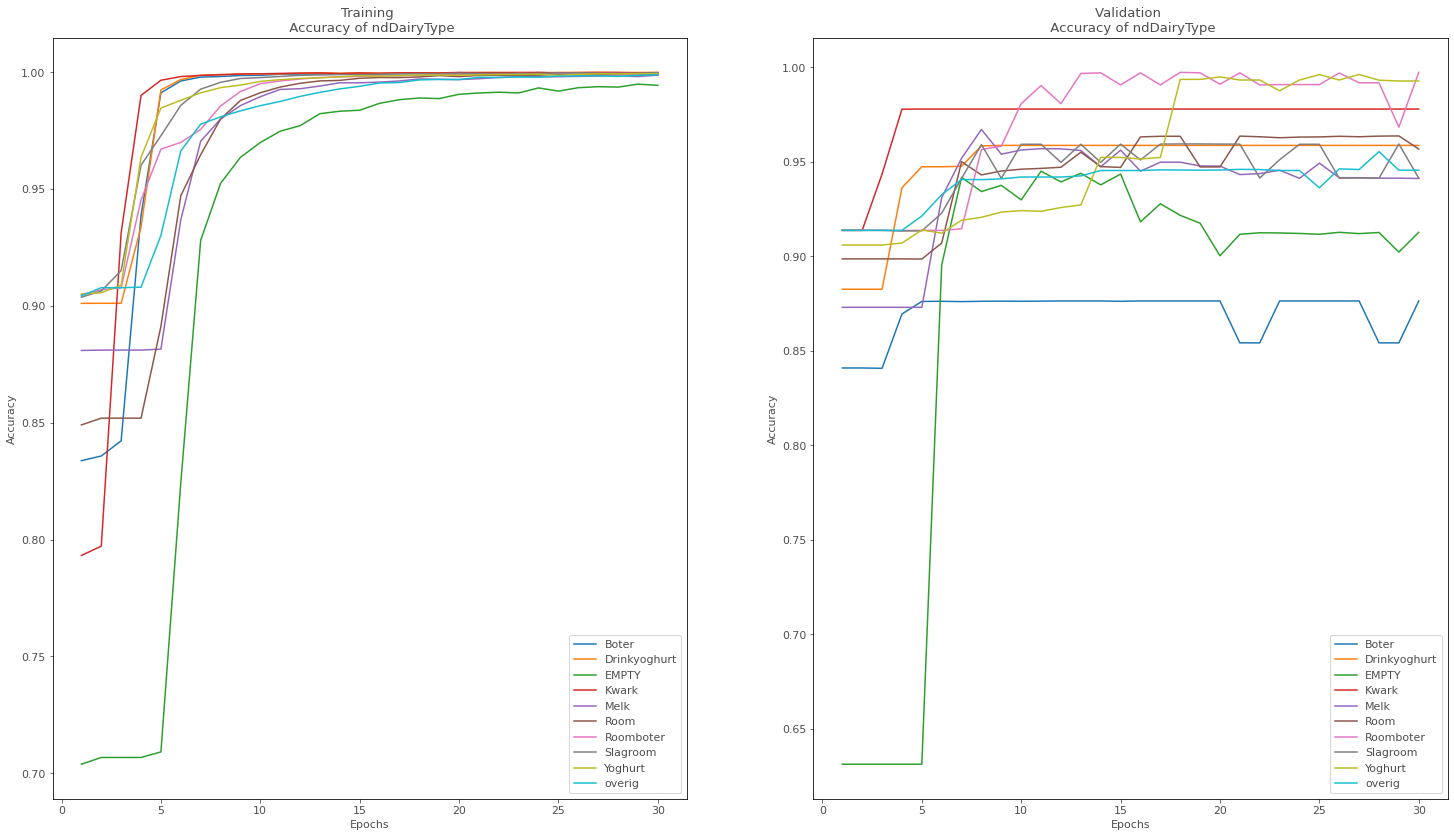

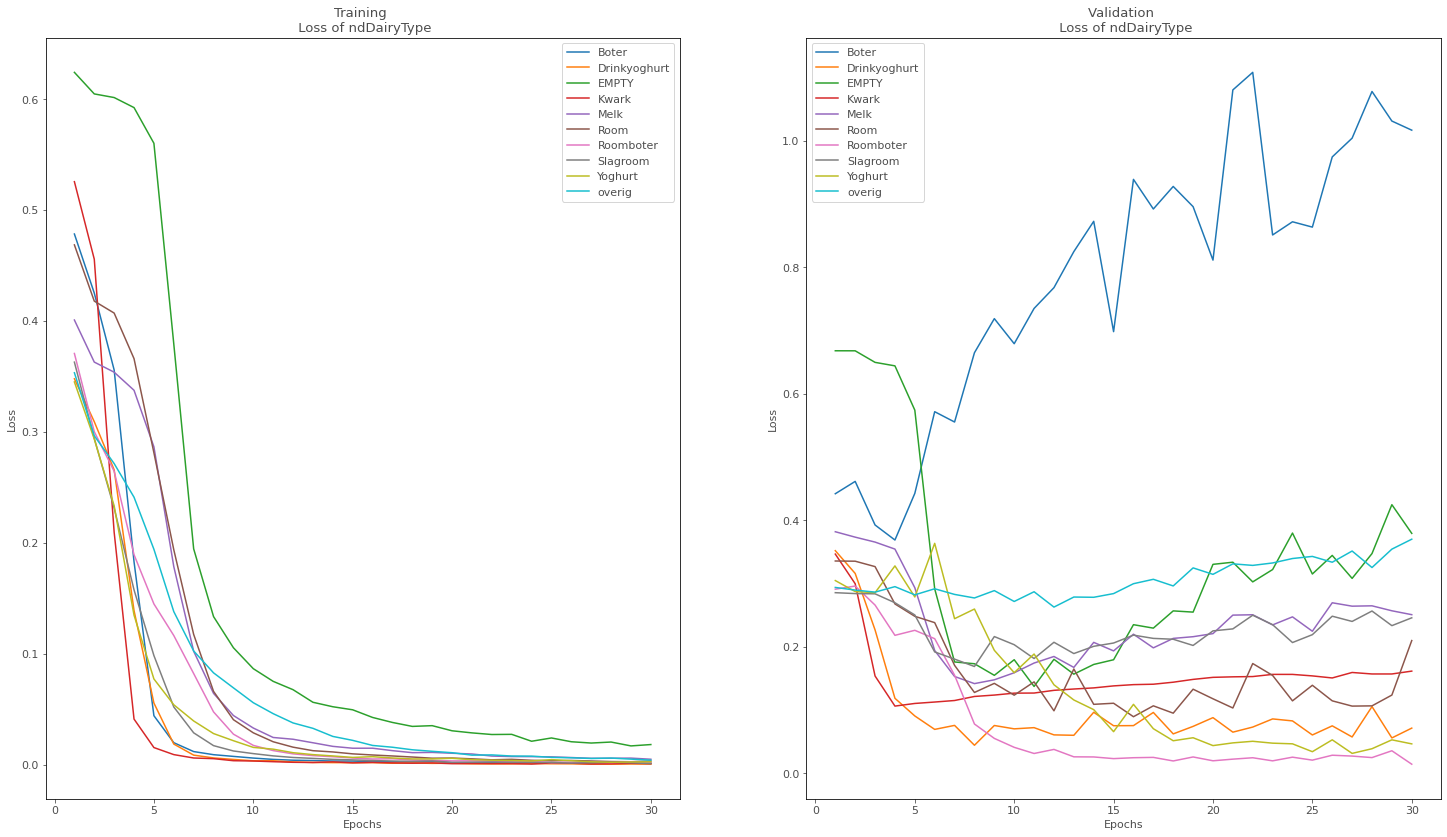

In [0]:
# Plot statistieken van de training fase
if multi_label_flag == True:
    plot_multiple_training(train_accuracies, val_accuracies, class_names, ATTRIBUUT, type_='Accuracy')
    plot_multiple_training(train_loss, val_loss, class_names, ATTRIBUUT, type_='Loss')
else:
    plot_single_label_training(model, model_history, Xtest_num, Xtest_text, ytest, ATTRIBUUT, DF_merged)
    